#### Intro
This notebook provides an introduction to employing Stable Diffusion for image production and manipulation within current workflows. We will briefly review the core features of these pipelines, postponing more in-depth analysis to another notebook. Specifically, our focus will include:

1. Generating images from text using the StableDiffusionPipeline and experimenting with various arguments.
2. Observing the operation of critical pipeline components, such as: - The VAE responsible for constructing a 'latent diffusion model'.
   - The tokenizer and text encoder that handle text prompts.
   - The UNet architecture itself.
   - The scheduler, with an exploration of several scheduling strategies.
3. Recreating the sampling process using the pipeline components.
4. Modifying existing pictures using the Img2Img pipeline.
5. Employing inpainting and Depth2Img pipelines for specialized tasks.


In [1]:
from utils import download_image
import torch
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

# We'll use a couple of demo images later in the notebook


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [3]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Generating Images from Text
We'll initialize a Stable Diffusion pipeline to examine its capabilities. There are numerous versions of Stable Diffusion available the latest version for its is 3, but for given case I will use the version 2.1.

In [4]:
# Load the pipeline
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

To avoid the Out of RAM (OOR) we can:
- Load the fp16 variant (not compatible with all systems). If we have to opt for this, you might also have to convert tensors to torch.float16 when testing individual components of the pipeline:

```python
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)
```

Activate attention slicing, which lowers GPU memory consumption albeit at a slight speed reduction:

```python
pipe.enable_attention_slicing()
```

- Decrease the size of the images. Once the pipeline is initialized, we can generate an image based on a prompt.

  0%|          | 0/35 [00:00<?, ?it/s]

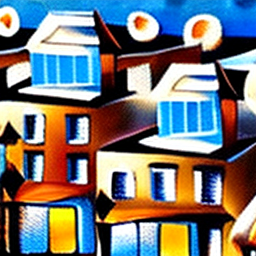

In [8]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=256, width=256,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

Important settings to adjust:

1. Width and height determine the dimensions of the created image. They must be divisible by 8 for compatibility with the VAE.
2. The number of processes influences the quality of generation. While the default setting (50) often provides good results, in certain circumstances, as little as 20 steps may serve, particularly for testing purposes.
3. The negative prompt is applied during the classifier-free guidance phase, offering an extra way of control.
4. The `guidance_scale` parameter impacts the strength of the classifier-free guidance (CFG). Higher scales encourage the generated images to better fit with the prompt. However, too high scales can lead to over-saturation and adverse effects.

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

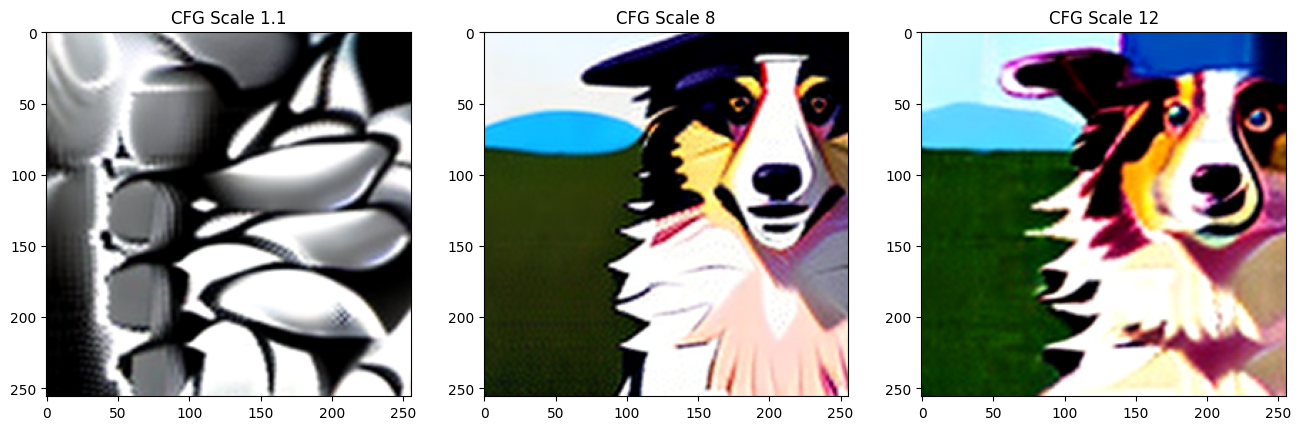

In [11]:
import os

os.environ["PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"

cfg_scales = [1.1, 8, 12] 
prompt = "A collie with a pink hat" 
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=256, width=256,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

#### Pipeline Components


In [ ]:
print(list(pipe.components.keys())) # List components


The StableDiffusionPipeline we're deploying is a bit more sophisticated than the DDPMPipeline we've mentioned in earlier work. In addition to the UNet and the scheduler, numerous additional components are added into the pipeline:


To obtain a deeper knowledge of how the pipeline performs, let's briefly examine each component in operation separately, and subsequently, connect them all to replicate the functionality of the pipeline independently.


#### The VAE

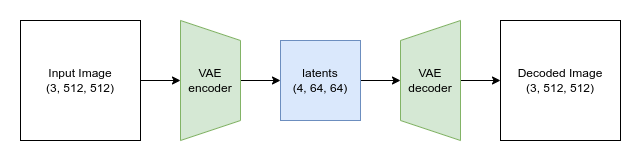

The VAE (Variational Autoencoder) is a model capable of compressing its input into a condensed representation and later decoding this 'latent' representation back into a form matching the original input. In the context of generating images with Stable Diffusion, the procedure involves initially generating latent representations by applying the diffusion process within the 'latent space' of the VAE, followed by decoding them to visualize the final image.

Below is some code demonstrating the process of encoding an input image into a latent representation and then decoding it using the VAE:


In [12]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


As clear, the 512x512 image undergoes compression to a 64x64 latent representation, with four channels. This 8x reduction in each spatial dimension highlights the necessity for the provided width and height to be multiples of 8.

Operating with these data-rich 4x64x64 latent representations is more efficient compared to handling huge 512px images. This promotes speedier diffusion models that demand fewer resources for training and deployment. Although the VAE decoding technique isn't faultless, the little quality compromise is often justified by the benefits it brings.


### The Tokenizer and Text Encoder

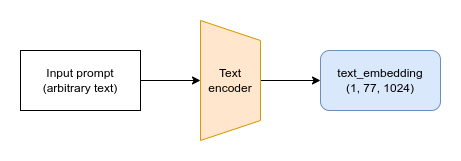

The purpose of the text encoder is to convert an input string (referred to as the prompt) into a numerical representation suitable for conditioning the UNet. Initially, the text is tokenized into a sequence of tokens using the pipeline's tokenizer. With a vocabulary comprising around 50k tokens, each word not included in this vocabulary is split into smaller sub-words. Subsequently, these tokens are transmitted via the text encoder model itself, which is a transformer model previously trained as the text encoder for CLIP. The idea is that this pretrained transformer model has learned complete representations of text that are advantageous for the diffusion job as well.

Let`s  analyze this process by encoding an example prompt, initially by manually tokenizing and passing it through the text encoder, and then via the pipeline's encode_prompt method to display the whole process, including padding or truncating the length to the maximum of 77 tokens.

In [13]:
# Tokenizing and encoding an example prompt manually
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [16]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe.encode_prompt("A painting of a flooble", device, 1, False, '')
text_embeddings

(tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
          [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
          [ 0.4134, -1.1114, -0.4718,  ...,  1.8329,  0.6236, -0.4375],
          ...,
          [ 0.5295, -1.6469, -0.0614,  ..., -0.2135, -0.0888,  0.0104],
          [ 0.5855, -1.6530, -0.1027,  ..., -0.4814, -0.1509,  0.1602],
          [ 0.3503, -2.4010, -0.8219,  ..., -0.2327, -0.0964,  0.8592]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 None)

The text embeddings, referred to as the `hidden states` originating from the last transformer block in the text encoder model, will serve as an extra parameter for the `forward` method of the UNet.


### The UNet

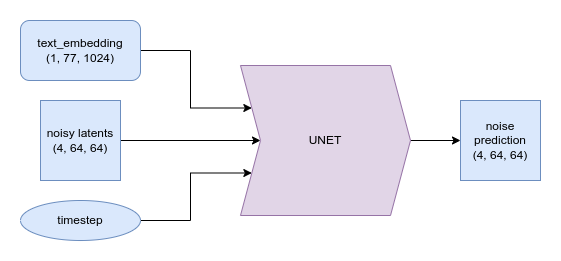

The UNet acts similarly to the ones we've encountered in previous chapters, accepting a noisy input and providing predictions for the noise. However, unlike those prior instances, the input here is not an image but a latent representation of an image. Moreover, in addition to timestep conditioning, this UNet also contains the text embeddings of the prompt as an extra input. Below, it's making predictions on simulated data.


In [17]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler
The scheduler preserves the noise schedule and oversees the adjustment of the noisy sample according to the model's predictions. While the default scheduler is a `PNDMScheduler`, alternative choices like `LMSDiscreteScheduler` are available, provided they are initialized with equivalent specifications.

We may display the noise schedule to see the noise level (given by $\bar{\alpha}$) with time.


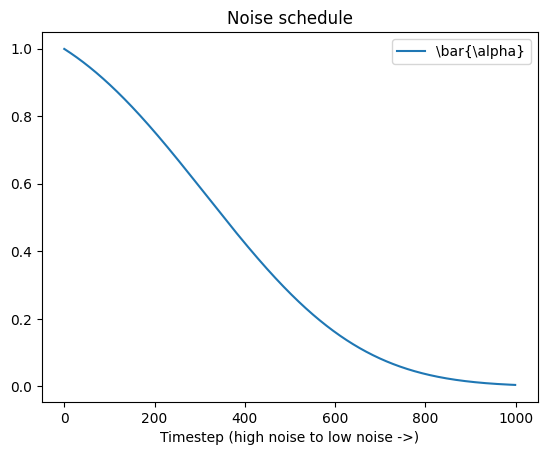

In [18]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'\bar{\alpha}')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

If you want to try out a different scheduler, you can swap in a new one as follows:

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}


  0%|          | 0/50 [00:00<?, ?it/s]

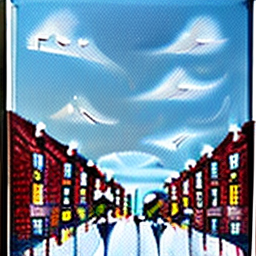

In [20]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=256, width=256,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

### A Sampling Loop
As we have discussed all of the components in a brief details, let see all in action.

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:561: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


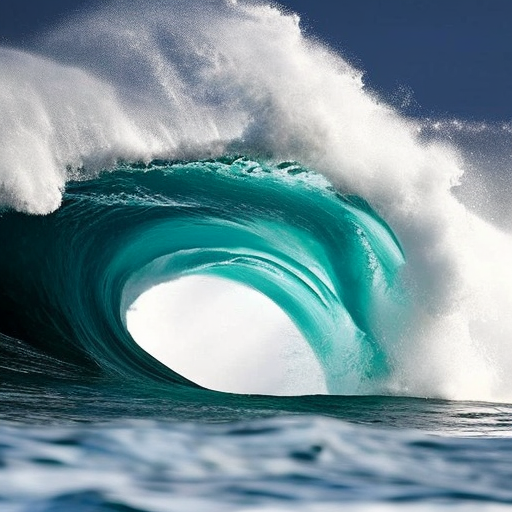

In [21]:
guidance_scale = 8 #@param
num_inference_steps = 30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

In many instances, utilizing the pre-existing pipelines will be more straightforward. However, having this adaptable sampling loop can be valuable for comprehending and adjusting the functionality of each component.